# Phobert - Rnn

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vsmec/test_nor_811.xlsx
/kaggle/input/vsmec/train_nor_811.xlsx
/kaggle/input/vsmec/valid_nor_811.xlsx


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [3]:
# Load dataset
train_df = pd.read_excel("/kaggle/input/vsmec/train_nor_811.xlsx", sheet_name="Sheet1")
test_df = pd.read_excel("/kaggle/input/vsmec/test_nor_811.xlsx", sheet_name="Sheet1")
valid_df = pd.read_excel("/kaggle/input/vsmec/valid_nor_811.xlsx", sheet_name="Sheet1")

Emotion
Enjoyment    1558
Disgust      1071
Other        1021
Sadness       947
Anger         391
Fear          318
Surprise      242
Name: count, dtype: int64
Tổng số lượng emotion: 5548


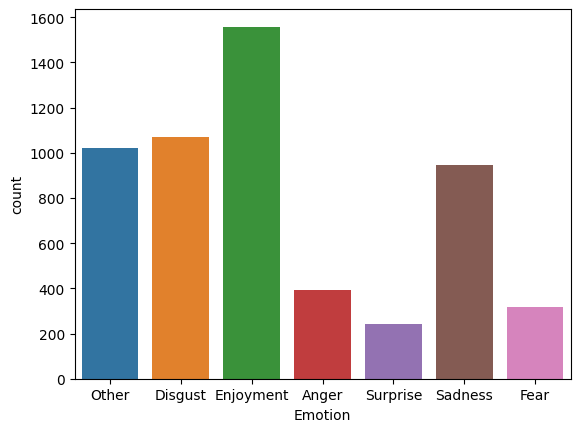

In [4]:
sns.countplot(x='Emotion', data=train_df)
label_counts = train_df['Emotion'].value_counts()
print(label_counts)
total_emotions = label_counts.sum()
print(f"Tổng số lượng emotion: {total_emotions}")

In [5]:
def convert_label(label):
    """Convert original emotion labels into simpler categories: neg, pos, neutral."""
    if pd.isna(label):
        return "neutral"
    label_mapping = {
        "sadness": "neg",
        "anger": "neg",
        "disgust": "neg",
        "fear": "neg",
        "enjoyment": "pos",
        "surprise": "pos",
        "other": "neutral"
    }
    return label_mapping.get(label.strip().lower(), "neutral")

Converted_Emotion
neg        2727
pos        1800
neutral    1021
Name: count, dtype: int64
Tổng số lượng emotion: 5548


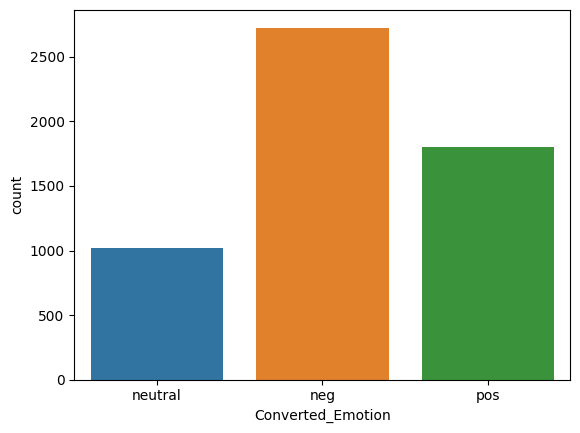

In [6]:
train_df['Converted_Emotion'] = train_df['Emotion'].apply(convert_label)
sns.countplot(x='Converted_Emotion', data=train_df)

label_counts = train_df['Converted_Emotion'].value_counts()
print(label_counts)
total_emotions = label_counts.sum()
print(f"Tổng số lượng emotion: {total_emotions}")

In [7]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors="pt")
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [9]:
datasets = {
    "train": SentimentDataset(train_df['Sentence'].tolist(), train_df['Converted_Emotion'].tolist(), tokenizer),
    "valid": SentimentDataset(valid_df['Sentence'].tolist(), valid_df['Converted_Emotion'].tolist(), tokenizer),
    "test": SentimentDataset(test_df['Sentence'].tolist(), test_df['Converted_Emotion'].tolist(), tokenizer)
}

dataloaders = {x: DataLoader(datasets[x], batch_size=16, shuffle=(x == "train")) for x in datasets}

KeyError: 'Converted_Emotion'

In [ ]:
class PhoBERT_Classifier(nn.Module):
    def __init__(self, num_classes=3):
        super(PhoBERT_Classifier, self).__init__()
        self.phobert = phobert
        self.rnn = nn.RNN(768, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        rnn_out, _ = self.rnn(outputs.last_hidden_state)
        out = self.fc(rnn_out[:, -1, :])  # Lấy hidden state cuối cùng của RNN
        return out

In [ ]:
model = PhoBERT_Classifier().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

def train_model(model, dataloaders, epochs=5):
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train, total_train = 0, 0
        for batch in dataloaders["train"]:
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['label'].cuda()
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = total_loss / len(dataloaders["train"])
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        model.eval()
        total_valid_loss = 0
        correct_valid, total_valid = 0, 0
        with torch.no_grad():
            for batch in dataloaders["valid"]:
                input_ids = batch['input_ids'].cuda()
                attention_mask = batch['attention_mask'].cuda()
                labels = batch['label'].cuda()
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                correct_valid += (preds == labels).sum().item()
                total_valid += labels.size(0)
        
        valid_loss = total_valid_loss / len(dataloaders["valid"])
        valid_acc = correct_valid / total_valid
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)
        
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_acc:.4f}, Valid Loss = {valid_loss:.4f}, Valid Accuracy = {valid_acc:.4f}")
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    
    return train_loss_history, valid_loss_history, train_acc_history, valid_acc_history

In [ ]:
train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = train_model(model, dataloaders)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label="Train Loss")
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss trong lúc train")

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['label'].cuda()
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    print(f"Test Accuracy: {correct / total:.4f}")

evaluate_model(model, dataloaders["test"])

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, len(valid_acc_history) + 1), valid_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy train và valid")

In [ ]:
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "phobert_sentiment_vsmec.pth")